## Prepare Data

In [ ]:
# First install package from terminal:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon  # autogluon==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 26.2 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/

In [ ]:
# import all required modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.inspection import permutation_importance

In [ ]:
# connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import dataset
file = '/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_mixed_discharge.csv'
raw_df = pd.read_csv(file, low_memory=False)

In [ ]:
# examine the variables (names)
raw_df.columns

Index(['Unnamed: 0', 'HADM_ID', 'subject_id', 'ethnicity', 'admission_type',
       'admission_location', 'insurance', 'religion', 'marital_status',
       'icu_los', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'resprate_min', 'resprate_max',
       'resprate_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hr_min',
       'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max',
       'temp_mean', 'sapsii', 'sofa', 'urine_min', 'urine_mean', 'urine_max',
       'patientweight', 'readmit_dt', 'age_cat', 'type_stay', 'prev_adm',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los',
       'dest_discharge', 'discharge'],
      dtype='object')

In [ ]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['Unnamed: 0', 'HADM_ID', 'subject_id','icu_los'])


In [ ]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(39841, 39105)

In [ ]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])
missing.sort_values('proportions',ascending = False)

,proportions
patientweight,0.515177
albumin_min,0.313771
type_stay,0.251477
calcium_min,0.024728
glucose_min,0.002966
glucose_mean,0.002966
glucose_max,0.002966
magnesium_max,0.002839
temp_mean,0.001585
temp_max,0.001585


In [ ]:
# drop variables having more than 20 % missing values
df = df.drop(columns=['albumin_min','patientweight','type_stay'])

In [ ]:
# save df
df_copy = df.copy()

In [ ]:
# impute missing values
df = df_copy.interpolate()
df.isna().mean()

ethnicity             0.0
admission_type        0.0
admission_location    0.0
insurance             0.0
religion              0.0
marital_status        0.0
gender                0.0
age                   0.0
urea_n_min            0.0
urea_n_max            0.0
urea_n_mean           0.0
platelets_min         0.0
platelets_max         0.0
platelets_mean        0.0
magnesium_max         0.0
calcium_min           0.0
resprate_min          0.0
resprate_max          0.0
resprate_mean         0.0
glucose_min           0.0
glucose_max           0.0
glucose_mean          0.0
hr_min                0.0
hr_max                0.0
hr_mean               0.0
sysbp_min             0.0
sysbp_max             0.0
sysbp_mean            0.0
diasbp_min            0.0
diasbp_max            0.0
diasbp_mean           0.0
temp_min              0.0
temp_max              0.0
temp_mean             0.0
sapsii                0.0
sofa                  0.0
urine_min             0.0
urine_mean            0.0
urine_max   

#### EDA

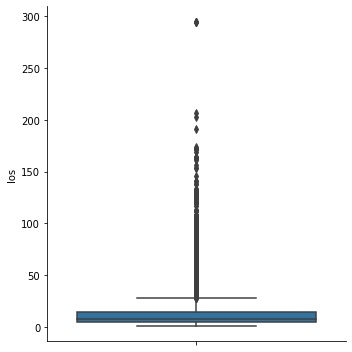

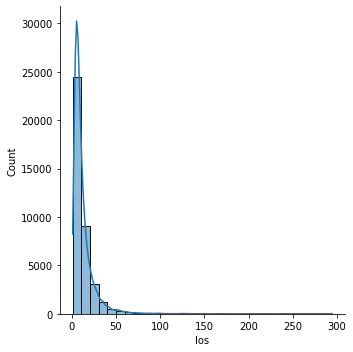

In [ ]:
# check distribution of outcome
sns.catplot(kind='box', data=df, y='los');
sns.displot(data=df, x="los", bins=30, kde=True) ;

In [ ]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.142, Third Quartile = 14.506, Interquartile Interval = 9.365
Lower Fence = -8.905, Upper Fence = 28.553


In [ ]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF
df = df.drop(columns=['los'])

## Heavier Preprocessing

In [ ]:
# PARAMETERS

preprocessing = True # set to true if we want to clean and perform some preprocessing
preproc_heavier = True # set to True if we want a heavier preprocessing
preproc_tag_2 = np.where(preproc_heavier, '_heavier', '')
preproc_tag = np.where(preprocessing, f'_preproc{preproc_tag_2}', f'{preproc_tag_2}')

In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
try:
  from unidecode import unidecode
except:
  !pip install unidecode
  from unidecode import unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 16.8 MB/s eta 0:00:00


In [ ]:
stemmer = SnowballStemmer("english", ignore_stopwords=True) # we initialize our stemmer
stop_words = stopwords.words('english') # nltk stopwords

In [ ]:
def remove_stopwords(text):
    text =  " ".join([x for x in text.split()if x not in stop_words]) # delete stopwords from text
    return text

def heading_clean(text):
  text = re.sub(r'\[\*\*(.+?)\*\*\]', "", text) # we take out information in brackets
  text = re.sub(r'(Admission Date:)|(Discharge Date:)|(Date of Birth:)|(Name:)|(Unit No:)', "", text, flags = re.I)
  if preproc_heavier:
    text = re.sub(r'Sex:', "", text, flags = re.I)
    text = text.lower() # lowercase text
    text = unidecode((text))
    text = re.sub(r'[^\w\s]','',text)
    text =  " ".join([stemmer.stem(x) for x in text.split()])
    text = remove_stopwords(text)
  return text

In [ ]:
if preprocessing:
  try:
    df = pd.read_feather(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_los{preproc_tag}')
    print('Dataframe Loaded')
  except:
    df['discharge'] = df.discharge.apply(lambda x: heading_clean(x))
    # need to reset the index
    df.reset_index(inplace=True, drop = True)
    # save our dataset up to now in feather format
    df.to_feather(f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/data/df_los{preproc_tag}')
    print('Dataframe Saved')

Dataframe Loaded


### Train/Test Split

In [ ]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

## Train the Tabular Model (Structured DataSet)

In [ ]:
# paramètres du modèle
if preprocessing:
  save_path = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/models/multimodal{preproc_tag}'
  print('With Preprocessing')
else:
  #save_path = '/content/drive/MyDrive/AutoGluon/models/multimodal_2022-05-29'
  save_path = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/models/multimodal{preproc_tag}'
  print('Without Preprocessing')
label = 'los_cat'
metric = 'roc_auc'

With Preprocessing


In [ ]:
from autogluon.tabular import TabularPredictor
try:
  predictor = TabularPredictor.load(save_path, require_version_match = False)
  print("Model Loaded")
except:
  print("Training Model")
  # run the tabular predictor ensemble of models (include 'multimodal' hyperparameter)
  predictor = TabularPredictor(label=label, eval_metric=metric,path=save_path)
  predictor.fit(df_train, hyperparameters='multimodal')


############################## WARNING ##############################
	Predictor Version: 0.4.2
	Current Version:   0.5.0
############################## WARNING ##############################



Model Loaded


In [ ]:
# evaluate performance on the test set
per_tab = predictor.evaluate(df_test)
per_tab

{'accuracy': 0.9588287942718322,
 'balanced_accuracy': 0.7612894359447608,
 'f1': 0.6567164179104478,
 'mcc': 0.6579800449431771,
 'precision': 0.8651685393258427,
 'recall': 0.5292096219931272,
 'roc_auc': 0.9694448123447401}

In [ ]:
# save the class and probability predictions
y_pred = predictor.predict(df_test)
y_pred_proba = predictor.predict_proba(df_test).iloc[:,1]

In [ ]:
# compute other metrics
def perf(y_test, y_pred, y_pred_proba):
  kappa = cohen_kappa_score(y_test, y_pred)
  precision, recall, prc_th = precision_recall_curve(y_test, y_pred_proba)
  prc_auc = auc(recall, precision)
  return kappa, prc_auc

perf = perf(df_test['los_cat'], y_pred, y_pred_proba)
perf_dict = {"Cohen's Kappa": perf[0], "PRC AUC": perf[1]}
perf_dict

{"Cohen's Kappa": 0.6361649730110202, 'PRC AUC': 0.7836858706574954}

In [ ]:
# path to save all the results
if preprocessing:
  path_results = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/results/multimodal'
else:
  #path_results = '/content/drive/MyDrive/AutoGluon/results/multimodal_2022-05-29'
  path_results = f'/content/drive/MyDrive/MIMIC-III Text Mining/LOS/results/multimodal'

In [ ]:
perf_dict.update(per_tab)

In [ ]:
# save performances
df_perf = pd.DataFrame.from_dict(perf_dict, orient='index', columns=['performances'])
df_perf.to_excel(path_results+f'/df_perf{preproc_tag}.xlsx')

In [ ]:
# compare the different models
leaderboard = predictor.leaderboard(df_test)
leaderboard

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Load pretrained checkpoint: /content/drive/MyDrive/MIMIC-III Text Mining/LOS/models/multimodal_preproc_heavier/models/TextPredictor/text_nn/model.ckpt


Predicting: 0it [00:00, ?it/s]

                 model  score_test  score_val  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2    0.969445   0.977437        2.851855       1.674912   296.214867                 0.007994                0.001941           1.253372            2       True          8
1             LightGBM    0.968369   0.976132        0.844369       0.532664    81.661188                 0.844369                0.532664          81.661188            1       True          1
2        LightGBMLarge    0.966521   0.972642        0.824926       0.499164    88.034527                 0.824926                0.499164          88.034527            1       True          6
3           LightGBMXT    0.966029   0.975233        0.882737       0.559099    84.738535                 0.882737                0.559099          84.738535            1       True          2
4              XGBoost    0.964088 

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.969445,0.977437,2.851855,1.674912,296.214867,0.007994,0.001941,1.253372,2,True,8
1,LightGBM,0.968369,0.976132,0.844369,0.532664,81.661188,0.844369,0.532664,81.661188,1,True,1
2,LightGBMLarge,0.966521,0.972642,0.824926,0.499164,88.034527,0.824926,0.499164,88.034527,1,True,6
3,LightGBMXT,0.966029,0.975233,0.882737,0.559099,84.738535,0.882737,0.559099,84.738535,1,True,2
4,XGBoost,0.964088,0.968039,3.760826,0.664338,66.539805,3.760826,0.664338,66.539805,1,True,4
5,CatBoost,0.961824,0.970391,2.095280,0.703544,2365.028155,2.095280,0.703544,2365.028155,1,True,3
6,NeuralNetTorch,0.951834,0.960242,0.291828,0.082044,40.527245,0.291828,0.082044,40.527245,1,True,5
7,TextPredictor,0.943332,0.943001,71.324465,12.032490,4262.961251,71.324465,12.032490,4262.961251,1,True,7


In [ ]:
# save leaderboard
leaderboard.to_excel(path_results+f'/leaderboard{preproc_tag}.xlsx')

In [ ]:
# compute feature importance
importance = predictor.feature_importance(df_test)
importance

These features in provided data are not utilized by the predictor and will be ignored: ['readmit_dt']


In [ ]:
# feature importance in percentage
importance['percent'] = 100*importance['importance']/importance['importance'].max()
importance

In [ ]:
# save importance
importance.to_excel(path_results+f'/importance{preproc_tag}.xlsx')